In [1]:
import optuna
import optuna.visualization as ov
from optuna.samplers import TPESampler
import plotly
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, auc
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [2]:
data = pd.read_csv('cleanedData.csv')
data = data.drop("Order", axis = 'columns')
data = data.drop("PID", axis = 'columns')
print(data.shape)
data.head()

(2930, 74)


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,3Ssn Porch,Screen Porch,Fence,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,HasFence
0,20,RL,141.0,31770,1,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,NoFence,0,5,2010,WD,Normal,215000,0
1,20,RH,80.0,11622,1,Reg,Lvl,AllPub,Inside,Gtl,...,0,120,MnPrv,0,6,2010,WD,Normal,105000,1
2,20,RL,81.0,14267,1,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,NoFence,12500,6,2010,WD,Normal,172000,0
3,20,RL,93.0,11160,1,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,NoFence,0,4,2010,WD,Normal,244000,0
4,60,RL,74.0,13830,1,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,MnPrv,0,3,2010,WD,Normal,189900,1


In [3]:
X, y = data.drop("SalePrice", axis = 'columns'), data['SalePrice']
X.head()


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Enclosed Porch,3Ssn Porch,Screen Porch,Fence,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,HasFence
0,20,RL,141.0,31770,1,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,NoFence,0,5,2010,WD,Normal,0
1,20,RH,80.0,11622,1,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,120,MnPrv,0,6,2010,WD,Normal,1
2,20,RL,81.0,14267,1,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,NoFence,12500,6,2010,WD,Normal,0
3,20,RL,93.0,11160,1,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,NoFence,0,4,2010,WD,Normal,0
4,60,RL,74.0,13830,1,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,MnPrv,0,3,2010,WD,Normal,1


In [4]:
y_classesI = pd.cut(
    y,
    bins=10, 
    labels=False, 
    include_lowest=True 
)
print(y_classesI.head())

0    2
1    1
2    2
3    3
4    2
Name: SalePrice, dtype: int64


In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encodedI = le.fit_transform(y_classesI.dropna())


In [6]:
X_numeric = pd.get_dummies(X) 
X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y_encodedI, test_size=0.1, random_state=42
)

In [7]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    model = XGBClassifier(
        **params,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=len(np.unique(y_classesI))
    )

    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)

    f1 = f1_score(y_test, y_pred, average='macro')
    return f1


In [8]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=10)


[I 2025-11-16 17:37:16,082] A new study created in memory with name: no-name-267d5617-3ef5-4844-9f5f-e545282b2414
[I 2025-11-16 17:37:22,154] Trial 0 finished with value: 0.5279229909617841 and parameters: {'max_depth': 4, 'learning_rate': 0.015630121576663627, 'n_estimators': 973, 'subsample': 0.9526746023145906, 'colsample_bytree': 0.7895386651521998, 'gamma': 3.8369882094828505, 'reg_alpha': 0.39076016017444903, 'reg_lambda': 0.8407600697332551}. Best is trial 0 with value: 0.5279229909617841.
[I 2025-11-16 17:37:24,044] Trial 1 finished with value: 0.44278796879172383 and parameters: {'max_depth': 12, 'learning_rate': 0.2789823236301363, 'n_estimators': 351, 'subsample': 0.5156252076680388, 'colsample_bytree': 0.989825272190684, 'gamma': 4.125375504232226, 'reg_alpha': 0.08943247925827158, 'reg_lambda': 0.565008148524506}. Best is trial 0 with value: 0.5279229909617841.
[I 2025-11-16 17:37:28,627] Trial 2 finished with value: 0.5424853135552062 and parameters: {'max_depth': 3, 'lea

In [9]:
best_trial = study.best_trial
print("Best Macro F1:", best_trial.value)
print("Best hyperparameters:", best_trial.params)


Best Macro F1: 0.5424853135552062
Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.29760689580743926, 'n_estimators': 908, 'subsample': 0.7476634150450323, 'colsample_bytree': 0.9994421728244658, 'gamma': 1.157631619110563, 'reg_alpha': 0.1770311673639806, 'reg_lambda': 0.505727937574634}


In [10]:
import nbformat
ov.plot_optimization_history(study).show()
ov.plot_param_importances(study).show()

In [11]:
best_params = best_trial.params
final_model = XGBClassifier(
    **best_params,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(np.unique(y_classesI))
)

final_model.fit(X_train, y_train)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9994421728244658
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [12]:
from sklearn.metrics import accuracy_score, classification_report
import sklearn
y_predI = final_model.predict(X_test)
y_probI = final_model.predict_proba(X_test)

print("\n Accuracy:", accuracy_score(y_test, y_predI))

print("\n f1 score: ", sklearn.metrics.f1_score(y_test, y_predI, average='weighted'))

print("\n Precision:", sklearn.metrics.precision_score(y_test, y_predI, average='weighted', zero_division=0))

print("\n Recall", sklearn.metrics.recall_score(y_test, y_predI, average='weighted', zero_division=0))

print("\n Predicted class labels:", y_predI[:5])
print(" Actual class labels   :", y_test[:5])


 Accuracy: 0.8191126279863481

 f1 score:  0.8146716932144941

 Precision: 0.8128147511587192

 Recall 0.8191126279863481

 Predicted class labels: [1 1 2 1 1]
 Actual class labels   : [1 1 2 1 1]


In [13]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=50)


[I 2025-11-16 17:37:57,621] A new study created in memory with name: no-name-ee986e50-c86f-4327-bc15-41d5c8408aaf
[I 2025-11-16 17:37:59,464] Trial 0 finished with value: 0.47330903649234757 and parameters: {'max_depth': 9, 'learning_rate': 0.25205734861127943, 'n_estimators': 205, 'subsample': 0.7316632436284483, 'colsample_bytree': 0.6358620451904781, 'gamma': 1.5466318739349667, 'reg_alpha': 0.87120346805536, 'reg_lambda': 0.3209634343553015}. Best is trial 0 with value: 0.47330903649234757.
[I 2025-11-16 17:38:03,034] Trial 1 finished with value: 0.5205841269205255 and parameters: {'max_depth': 11, 'learning_rate': 0.17324483375662875, 'n_estimators': 539, 'subsample': 0.8992085487310986, 'colsample_bytree': 0.9504944029263974, 'gamma': 4.043401899176641, 'reg_alpha': 0.5393847289173999, 'reg_lambda': 0.9585666647174722}. Best is trial 1 with value: 0.5205841269205255.
[I 2025-11-16 17:38:10,629] Trial 2 finished with value: 0.46053550022244377 and parameters: {'max_depth': 6, 'lea

In [14]:
best_trial = study.best_trial
print("Best Macro F1:", best_trial.value)
print("Best hyperparameters:", best_trial.params)


Best Macro F1: 0.5471474634685787
Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.04848101523931791, 'n_estimators': 644, 'subsample': 0.5629387668022501, 'colsample_bytree': 0.7117711118875907, 'gamma': 1.8915218097927384, 'reg_alpha': 0.34121976757809386, 'reg_lambda': 0.8802697286143059}


In [15]:
ov.plot_optimization_history(study).show()
ov.plot_param_importances(study).show()

In [16]:
best_params = best_trial.params
final_model = XGBClassifier(
    **best_params,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(np.unique(y_classesI))
)

final_model.fit(X_train, y_train)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7117711118875907
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [17]:
from sklearn.metrics import accuracy_score, classification_report
import sklearn
y_predI = final_model.predict(X_test)
y_probI = final_model.predict_proba(X_test)

print("\n Accuracy:", accuracy_score(y_test, y_predI))

print("\n f1 score: ", sklearn.metrics.f1_score(y_test, y_predI, average='weighted'))

print("\n Precision:", sklearn.metrics.precision_score(y_test, y_predI, average='weighted', zero_division=0))

print("\n Recall", sklearn.metrics.recall_score(y_test, y_predI, average='weighted', zero_division=0))

print("\n Predicted class labels:", y_predI[:5])
print(" Actual class labels   :", y_test[:5])


 Accuracy: 0.8191126279863481

 f1 score:  0.8140505138876298

 Precision: 0.8101207282229378

 Recall 0.8191126279863481

 Predicted class labels: [1 1 2 1 1]
 Actual class labels   : [1 1 2 1 1]


In [18]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=30)

[I 2025-11-16 17:41:24,785] A new study created in memory with name: no-name-90ee3d23-903a-4ddd-8587-87a5c68c0977
[I 2025-11-16 17:41:27,904] Trial 0 finished with value: 0.5278539380059344 and parameters: {'max_depth': 9, 'learning_rate': 0.10694618031520695, 'n_estimators': 517, 'subsample': 0.6017822266338755, 'colsample_bytree': 0.8530869397085015, 'gamma': 1.6315294552237214, 'reg_alpha': 0.21795180780901324, 'reg_lambda': 0.7702138524072593}. Best is trial 0 with value: 0.5278539380059344.
[I 2025-11-16 17:41:29,977] Trial 1 finished with value: 0.4688000684579807 and parameters: {'max_depth': 5, 'learning_rate': 0.283052191065812, 'n_estimators': 375, 'subsample': 0.5138778739211038, 'colsample_bytree': 0.795503881529207, 'gamma': 2.145998142662055, 'reg_alpha': 0.820192819481949, 'reg_lambda': 0.5654934554945856}. Best is trial 0 with value: 0.5278539380059344.
[I 2025-11-16 17:41:31,427] Trial 2 finished with value: 0.4819346717818157 and parameters: {'max_depth': 8, 'learning

In [19]:
best_trial = study.best_trial
print("Best Macro F1:", best_trial.value)
print("Best hyperparameters:", best_trial.params)

Best Macro F1: 0.5397809549125339
Best hyperparameters: {'max_depth': 10, 'learning_rate': 0.04856274907113815, 'n_estimators': 359, 'subsample': 0.5541288864507885, 'colsample_bytree': 0.8392610663527316, 'gamma': 3.717080272389325, 'reg_alpha': 0.39138246588471887, 'reg_lambda': 0.4264712097514904}


In [20]:
best_params = best_trial.params
final_model = XGBClassifier(
    **best_params,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(np.unique(y_classesI))
)

final_model.fit(X_train, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8392610663527316
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [21]:
from sklearn.metrics import accuracy_score, classification_report
import sklearn
y_predI = final_model.predict(X_test)
y_probI = final_model.predict_proba(X_test)

print("\n Accuracy:", accuracy_score(y_test, y_predI))

print("\n f1 score: ", sklearn.metrics.f1_score(y_test, y_predI, average='weighted'))

print("\n Precision:", sklearn.metrics.precision_score(y_test, y_predI, average='weighted', zero_division=0))

print("\n Recall", sklearn.metrics.recall_score(y_test, y_predI, average='weighted', zero_division=0))

print("\n Predicted class labels:", y_predI[:5])
print(" Actual class labels   :", y_test[:5])


 Accuracy: 0.8225255972696246

 f1 score:  0.8165418631558383

 Precision: 0.8109959819441791

 Recall 0.8225255972696246

 Predicted class labels: [1 1 2 1 1]
 Actual class labels   : [1 1 2 1 1]


ROC Curve for Multi-Class XGBoost

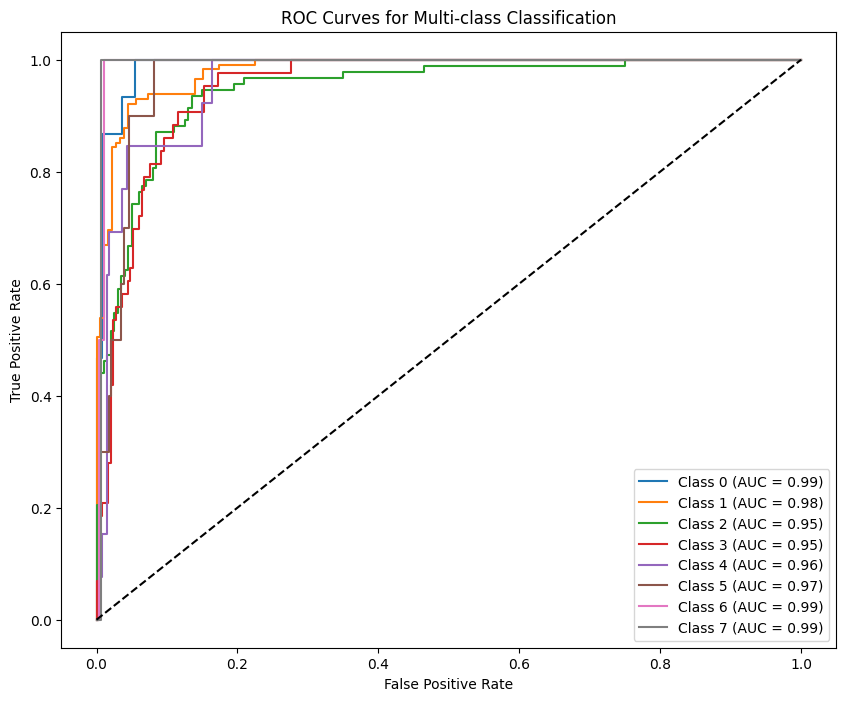

In [23]:
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probI[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class Classification')
plt.legend(loc='lower right')
plt.show()

In [26]:
best_treshold = {}
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr, tpr, thresholds = roc_curve(y_test_bin[:, i], y_probI[:, i])
    j_scores = tpr - fpr
    best_threshold_index = np.argmax(j_scores)

    best_treshold[i] = {
        'threshold': thresholds[best_threshold_index],
        'tpr': tpr[best_threshold_index],
        'fpr': fpr[best_threshold_index]
    }

print("Best thresholds for each class:")
for cls, vals in best_treshold.items():
    print(f"Class {cls}: Threshold = {vals['threshold']:.4f}, TPR = {vals['tpr']:.4f}, FPR = {vals['fpr']:.4f}")

Best thresholds for each class:
Class 0: Threshold = 0.0767, TPR = 1.0000, FPR = 0.0540
Class 1: Threshold = 0.5170, TPR = 0.9217, FPR = 0.0449
Class 2: Threshold = 0.2596, TPR = 0.9355, FPR = 0.1350
Class 3: Threshold = 0.0898, TPR = 0.9767, FPR = 0.1720
Class 4: Threshold = 0.0398, TPR = 1.0000, FPR = 0.1643
Class 5: Threshold = 0.0197, TPR = 1.0000, FPR = 0.0813
Class 6: Threshold = 0.0747, TPR = 1.0000, FPR = 0.0103
Class 7: Threshold = 0.0237, TPR = 1.0000, FPR = 0.0069


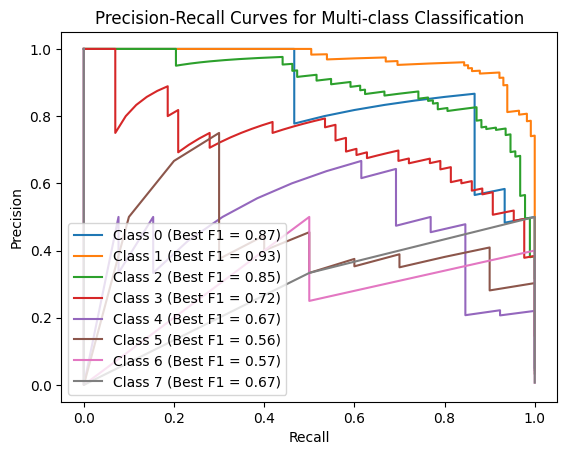

Best PR thresholds per class: {0: np.float32(0.5075634), 1: np.float32(0.51696914), 2: np.float32(0.46696937), 3: np.float32(0.34829444), 4: np.float32(0.43803647), 5: np.float32(0.041226115), 6: np.float32(0.074707896), 7: np.float32(0.023687305)}


In [40]:
from sklearn.metrics import precision_recall_curve

best_pr_thresholds = {}
n_classes = y_test_bin.shape[1]

plt.figure()
for i in range(n_classes):
    precision, recall, thresholds = precision_recall_curve(y_test_bin[:, i], y_probI[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_pr_thresholds[i] = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    plt.plot(recall, precision, label=f'Class {i} (Best F1 = {f1_scores[best_idx]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Multi-class Classification')
plt.legend()
plt.show()
print("Best PR thresholds per class:", best_pr_thresholds)


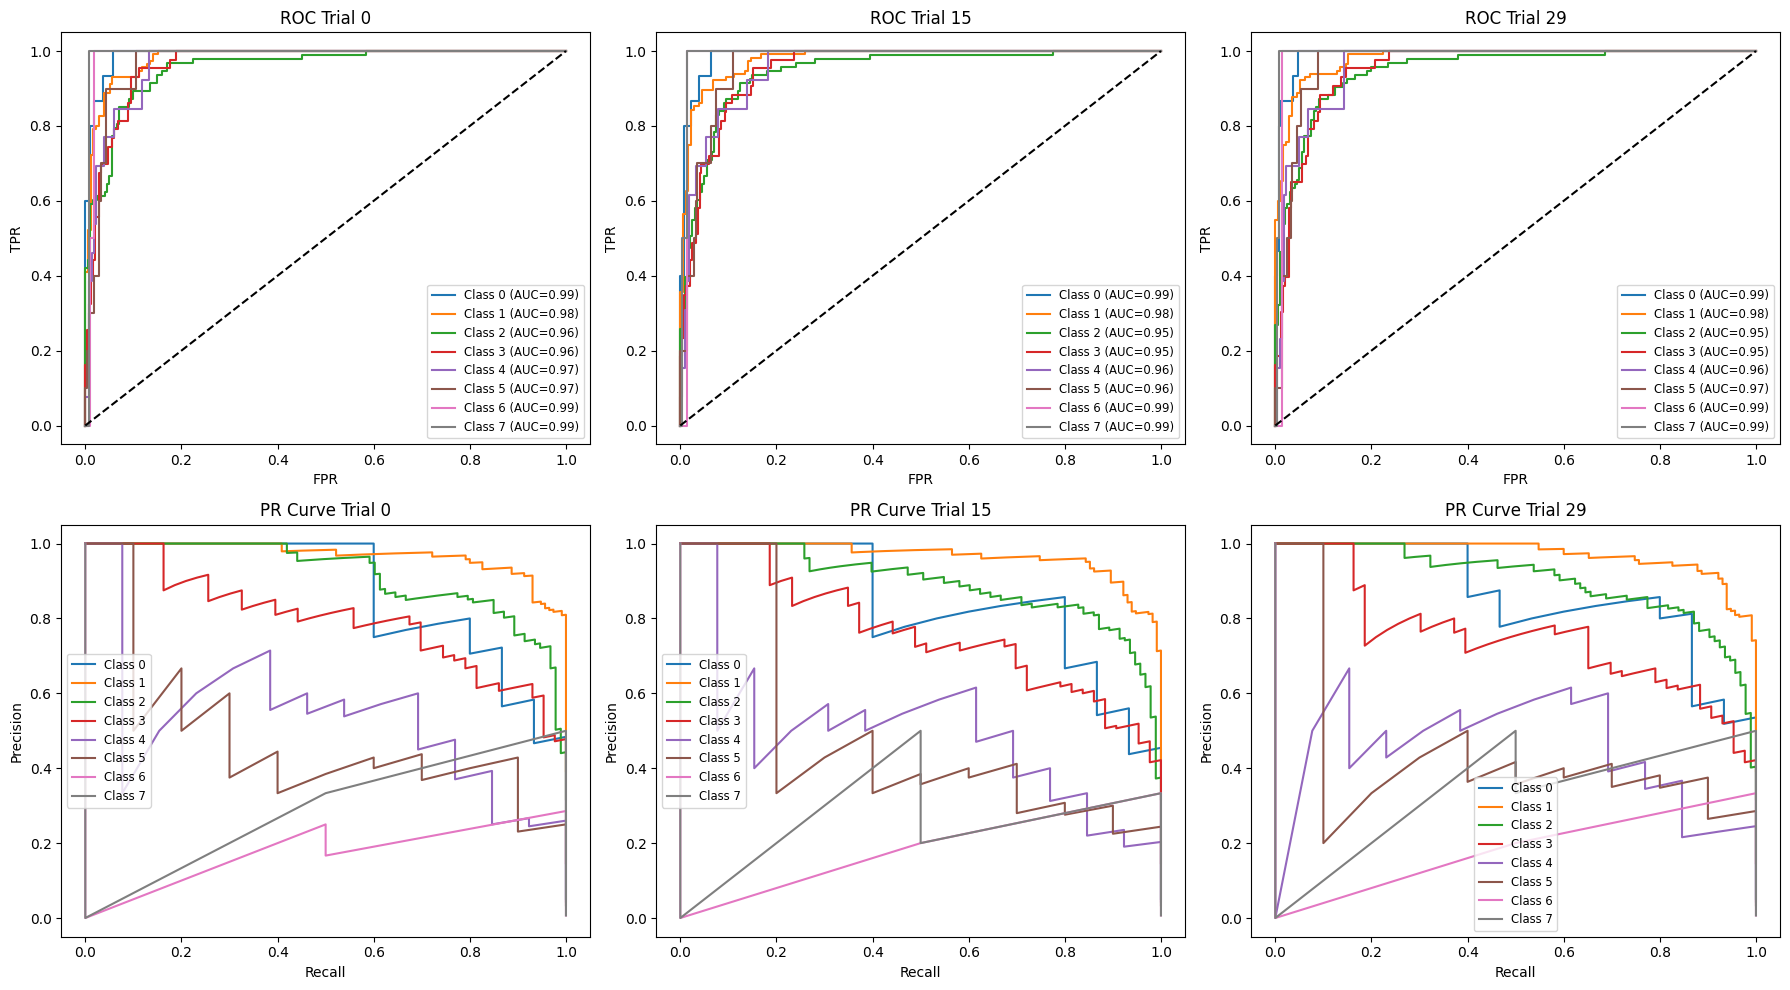

In [42]:
n_classes = y_test_bin.shape[1]
iteration_indices = [0, len(study.trials)//2, len(study.trials)-1]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for col_idx, trial_idx in enumerate(iteration_indices):
    trial_params = study.trials[trial_idx].params
    iter_model = XGBClassifier(
        **trial_params,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=n_classes
    )
    iter_model.fit(X_train, y_train)
    y_prob_iter = iter_model.predict_proba(X_test)
    
    # ROC Curve
    ax_roc = axes[0, col_idx]
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_iter[:, i])
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')
    ax_roc.plot([0, 1], [0, 1], 'k--')
    ax_roc.set_title(f'ROC Trial {trial_idx}')
    ax_roc.set_xlabel('FPR')
    ax_roc.set_ylabel('TPR')
    ax_roc.legend(fontsize='small')

    # Precision-Recall Curve
    ax_pr = axes[1, col_idx]
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob_iter[:, i])
        ax_pr.plot(recall, precision, label=f'Class {i}')
    ax_pr.set_title(f'PR Curve Trial {trial_idx}')
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.legend(fontsize='small')

plt.tight_layout()
plt.show()


In [27]:
yD = data["SalePrice"]

n_classes = 10
min_val, max_val = yD.min(), yD.max()
internal_edges = np.linspace(min_val, max_val, n_classes - 2)  
internal_edges = internal_edges[1:-1] 
bins = [-np.inf] + internal_edges.tolist() + [np.inf]

y_classD = pd.cut(y, bins=bins, labels=False)
y_classD

0       1
1       0
2       1
3       2
4       1
       ..
2925    1
2926    1
2927    1
2928    1
2929    1
Name: SalePrice, Length: 2930, dtype: int64

In [32]:
Xd = data.drop(columns=["SalePrice"])
Xd = pd.get_dummies(Xd)
X_trainD, X_testD, y_trainD, y_testD = train_test_split(
    Xd, y_classD,                      # <- actual regression target or same y
    stratify=y_classD,          # <- temporary labels used ONLY for stratification
    test_size=0.1,
    random_state=42
)

In [33]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_classD),
    y=y_classD
)

In [34]:
def objectiveD(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    model = XGBClassifier(
        **params,
        eval_metric='mlogloss',
        objective='multi:softprob',
        num_class=len(np.unique(y_classD))
    )

    model.fit(X_trainD, y_trainD)
    y_pred_probaD = model.predict_proba(X_testD)
    y_predD = np.argmax(y_pred_probaD, axis=1)

    f1 = f1_score(y_testD, y_predD, average='macro')
    return f1


In [35]:
studyD = optuna.create_study(direction='maximize', sampler=TPESampler())
studyD.optimize(objectiveD, n_trials=50)

[I 2025-11-16 18:17:17,705] A new study created in memory with name: no-name-5ff5f5a3-46af-4819-b0a9-b0173a8de8d2
[I 2025-11-16 18:17:19,058] Trial 0 finished with value: 0.62625021505993 and parameters: {'max_depth': 12, 'learning_rate': 0.15846681081425873, 'n_estimators': 314, 'subsample': 0.582964157908155, 'colsample_bytree': 0.7801850883314744, 'gamma': 4.019743744708277, 'reg_alpha': 0.15719886316592724, 'reg_lambda': 0.39153873333205336}. Best is trial 0 with value: 0.62625021505993.
[I 2025-11-16 18:17:20,854] Trial 1 finished with value: 0.5619871812806595 and parameters: {'max_depth': 11, 'learning_rate': 0.1979477972741628, 'n_estimators': 448, 'subsample': 0.666701153645317, 'colsample_bytree': 0.5954914264752564, 'gamma': 4.874610410501747, 'reg_alpha': 0.535060897050965, 'reg_lambda': 0.022810719279027558}. Best is trial 0 with value: 0.62625021505993.
[I 2025-11-16 18:17:24,003] Trial 2 finished with value: 0.6103842853842854 and parameters: {'max_depth': 8, 'learning_r

In [ ]:
import joblib

joblib.dump(study, "study.pkl")

# Save final model trained on best params
final_model = XGBClassifier(
    **study.best_trial.params,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(np.unique(y_classD))
)
final_model.fit(X_trainD, y_trainD)
joblib.dump(final_model, "final_model.pkl")